## TRAINING
This notebook has as an objective to use a folder containing the formated .npy files to train a deep learning model that can be used in lieu of an FEA model to any accuracy above random, for a proof of concept that it is possible to do so, such that further research can be done afterward to optimize architecture, hyperparameters and data being fed in.

In [1]:
##  imports

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pathlib
import PREPROCESSING_splitting as split
import matplotlib.pyplot as plt

splitting functions imported


## WEIGHTS AND BIASES
This section's purpose  is to set up logging for the tests

In [2]:
import wandb

In [3]:
#import importlib
#importlib.reload(torch)

In [3]:
## first, create a class to load the files that are to be fed to the neural network, 
## for both the inputs and the outputs. To avoid confusion I'll refer to the inputs to the 
## FEA model as 'bound_conds' (boundary conditions), and the outputs as 'targets', while what 
## is fed into the neural network will be called an "input", and the output of the neural network "prediction"
## this function should probably be transformed into a dataloader later for a larger dataset, 
## but for now we'll keep it like this

def get_dataset(dataset_path, glob_parameter = '*.npy'):
    # concatenates all samples into a list of boundary conditions and a list of targets
    
    # set paths
    bound_cond_path = pathlib.Path(dataset_path, 'input')
    targets_path = pathlib.Path(dataset_path, 'output')

    test = pathlib.Path('D:/')
    
    
    
    
    # check if folder path is correct
    if bound_cond_path.is_dir() and targets_path.is_dir():
        print('path contains \'input\' and \'output\'')
        pass
    else:
        raise Exception (f'Argument dataset_path: {dataset_path} should contain folders ..\input and ..\output. Please check path')
    
    #create iterators for files
    bound_cond_iterator = bound_cond_path.glob(glob_parameter)
    targets_iterator = targets_path.glob(glob_parameter)
    
    #zip them to ensure that they are going through the same samples 
    samples_iterator = zip(bound_cond_iterator, targets_iterator)
    
    boundary_conditions = np.array([])
    targets = np.array([])
    
    for boundary_condition_files, targets_files in samples_iterator:
        if split.get_number(boundary_condition_files.name) == split.get_number(targets_files.name):
            
            boundary_conditions_temp = np.load(boundary_condition_files)
            targets_temp = np.load(targets_files)
            
            #start array if it hasn't been started yet
            if boundary_conditions.size == 0 and targets.size == 0:
                boundary_conditions = boundary_conditions_temp
                targets = targets_temp
            else:
                boundary_conditions = np.concatenate((boundary_conditions, boundary_conditions_temp), axis = 0)
                targets = np.concatenate((targets, targets_temp), axis = 0)
        else:
            raise Exception('the samples in the iterator are not synced')
    
    return torch.from_numpy(boundary_conditions).float(), torch.from_numpy(targets).float()
    

In [4]:
folders_path =  pathlib.Path('D:/Ansys Simulations/Project/2D/data/proof_of_concept/scaled/arrays')
dataset = get_dataset(dataset_path = folders_path)
print(dataset[0].shape)
print(dataset[1].shape)

path contains 'input' and 'output'
torch.Size([102, 7, 32, 32])
torch.Size([102, 4, 32, 32])


## BASE

In [93]:
## define the neural network's general shape

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        ## convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 7, out_channels = 14, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 14, out_channels = 16, kernel_size = 3, padding = 1)
        self.deconv1 = nn.ConvTranspose2d(in_channels = 16, out_channels = 14, kernel_size = 3, padding = 1)
        self.deconv2 = nn.ConvTranspose2d(in_channels = 14, out_channels = 10, kernel_size = 3, padding = 1)
        self.deconv3 = nn.ConvTranspose2d(in_channels = 10, out_channels = 7, kernel_size = 3, padding = 1)
        self.deconv4 = nn.ConvTranspose2d(in_channels = 7, out_channels = 3, kernel_size = 3, padding = 1)
        
        ## activation
        self.hardtanh = nn.Hardtanh()
        
        
        ##possible for later: MultiheadAttention
        
    def forward(self, boundary_conditions):
        #print(boundary_conditions.shape)
        x = self.conv1(boundary_conditions)
        x = self.hardtanh(x)
        #print(x.shape)
        x = self.conv2(x)
        x = self.hardtanh(x)
        #print(x.shape)
        x = self.deconv1(x)
        x = self.hardtanh(x)
       #print(x.shape)
        x = self.deconv2(x)
        x = self.hardtanh(x)
        #print(x.shape)
        x = self.deconv3(x)
        x = self.hardtanh(x)
       # print(x.shape)
        x = self.deconv4(x)
        x = self.hardtanh(x)
        #print(x.shape)
        return x
    
net = ConvNet().cuda().float()

## test to see if getting the correct size
net.forward(dataset[0][0:1,:,:,:].cuda())

tensor([[[[-0.1848, -0.1949, -0.2107,  ..., -0.2141, -0.2092, -0.2141],
          [-0.1324, -0.1882, -0.2108,  ..., -0.2065, -0.2063, -0.2438],
          [-0.1320, -0.1593, -0.1823,  ..., -0.1713, -0.1719, -0.2261],
          ...,
          [-0.1375, -0.1567, -0.1692,  ..., -0.1834, -0.1763, -0.2223],
          [-0.1251, -0.1263, -0.1496,  ..., -0.1626, -0.1729, -0.2059],
          [-0.1521, -0.1681, -0.1941,  ..., -0.1833, -0.1822, -0.2015]],

         [[-0.0021,  0.0233,  0.0171,  ...,  0.0139,  0.0210,  0.0515],
          [-0.0110,  0.0339,  0.0221,  ...,  0.0152,  0.0098,  0.0695],
          [-0.0095,  0.0590,  0.0451,  ...,  0.0397,  0.0394,  0.0835],
          ...,
          [-0.0168,  0.0678,  0.0430,  ...,  0.0276,  0.0257,  0.0789],
          [ 0.0065,  0.0776,  0.0622,  ...,  0.0415,  0.0328,  0.0763],
          [ 0.0273,  0.0918,  0.0809,  ...,  0.0816,  0.0790,  0.0800]],

         [[-0.1435, -0.1662, -0.1835,  ..., -0.1640, -0.1638, -0.1844],
          [-0.1226, -0.1210, -

In [94]:
## define criterion
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(params = net.parameters(), lr=0.0001, betas=(0.9, 0.999))

In [95]:
## setup logging
wandb.init(config={"epochs": 50, "batch_size": 90, 'architecture':'base_architecture'})

W&B Run: https://app.wandb.ai/walther/Project/runs/23avobon

In [78]:
wandb.config.update({"epochs": 50, "batch_size": 90, 'dataset':'base_architecture'}) 

In [96]:
%%wandb


## define a general training loop
losses = np.array([0,0,0])
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    boundary_conditions, targets = dataset[0][:90,:,:,:].cuda(), dataset[1][:90,:,:,:].cuda()
    #print(type(boundary_conditions))
    #net = net.cuda()
    for i, bc in enumerate(boundary_conditions):
        tgt = targets[i, 1:4, :, :].unsqueeze(0)
        bc = bc.unsqueeze(0)
        #print(i, bc.shape, tgt.shape)

        # get the inputs; data is a list of [boundary_conditions, targets]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        prediction = net(bc)
        loss = criterion(prediction, tgt)
        #print(loss)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 10 mini-batches
            running_val_loss = 0.0
            with torch.no_grad():
                boundary_conditions_val, targets_val = dataset[0][90:,:,:,:].cuda(), dataset[1][90:,:,:,:].cuda()
                for ii, bc_val in enumerate(boundary_conditions_val):
                    tgt_val = targets_val[i, 1:4, :, :].unsqueeze(0)
                    bc_val = bc_val.unsqueeze(0)
                    prediction_val = net(bc_val)
                    val_loss = criterion(prediction_val, tgt_val)
                    
                    running_val_loss+=val_loss.item()
                
            print(f'{epoch + 1} {i + 1} {running_loss} {running_val_loss/10}')
            wandb.log({"loss": running_loss})
            wandb.log({"val_loss": running_val_loss})
            losses = np.vstack((losses, [epoch, running_loss, running_val_loss]))
            #print(losses)
            running_loss = 0.0
            

print('Finished Training')

1 1 0.016714144498109818 0.019145140890032053
2 1 0.0011802840745076537 0.0014103455818258227
3 1 0.0009948427323251963 0.001163372053997591
4 1 0.0008658082224428654 0.0010032846708782016
5 1 0.0007614213973283768 0.0008792710024863482
6 1 0.0006741338293068111 0.000778469064971432
7 1 0.000600143801420927 0.0006948199181351811
8 1 0.0005372070008888841 0.0006248694495297969
9 1 0.00048348819836974144 0.0005661065428284928
10 1 0.00043713697232306004 0.000516299981973134
11 1 0.0003964062489103526 0.00047348100633826107
12 1 0.0003599087649490684 0.0004361393366707489
13 1 0.0003267583088018 0.00040332775097340345
14 1 0.0002965453313663602 0.0003745863679796457
15 1 0.0002692050766199827 0.0003497604833682999
16 1 0.000244844559347257 0.0003288008534582332
17 1 0.00022357015404850245 0.0003116030507953838
18 1 0.00020535557996481657 0.0002979214375955053
19 1 0.00018998519226443022 0.0002873686811653897
20 1 0.00017708781524561346 0.0002794800253468566
21 1 0.0001662269642110914 0.00

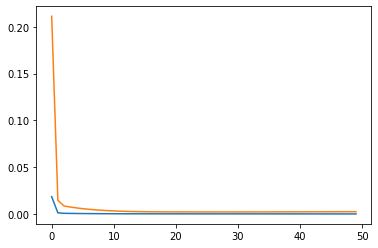

In [7]:
## attempt to plot losses over time
plt.plot(losses[1:,0], losses[1:,1:])

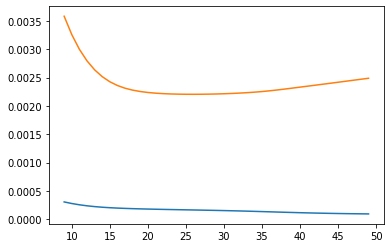

In [8]:
## attempt to plot losses over time to sho where the model started overfitting on the data
plt.plot(losses[10:,0], losses[10:,1:])

Therefore, it can be seen that the network learns some of the relationships in the dataset, and is able to overfit it after a while.

In [14]:
%matplotlib inline 
#f = plt.figure()


#plt.imshow(concat_input[:,:,0])
def plot_grid_2d(concat_input, concat_output):
    
    f, axarr = plt.subplots(2,5, figsize = (15,6)) 
    
    axarr[0,0].imshow(np.abs(concat_input[:,:,0]))
    axarr[0,0].set(title='smoothed map')

    axarr[0,1].imshow(np.abs(concat_input[:,:,1]))
    axarr[0,1].set(title='X displacement B.C.')

    axarr[0,2].imshow(np.abs(concat_input[:,:,2]))
    axarr[0,2].set(title='Y displacement B.C.')

    axarr[0,3].imshow(np.abs(concat_input[:,:,3]))
    axarr[0,3].set(title='Z displacement  B.C')

    axarr[0,4].imshow(np.abs(concat_input[:,:,4]))
    axarr[0,4].set(title='X force B.C.')

    axarr[1,0].imshow(np.abs(concat_input[:,:,5]))
    axarr[1,0].set(title='Y force B.C.')

    axarr[1,1].imshow(np.abs(concat_input[:,:,6]))
    axarr[1,1].set(title='Z force B.C.')

    axarr[1,2].imshow(np.abs(concat_output[:,:,1]))
    axarr[1,2].set(title='X displacement result')

    axarr[1,3].imshow(np.abs(concat_output[:,:,2]))
    axarr[1,3].set(title='Y displacement result')

    axarr[1,4].imshow(np.abs(concat_output[:,:,3]))
    axarr[1,4].set(title='Z displacement result')

    plt.show()

(32, 32, 7) (32, 32, 4)


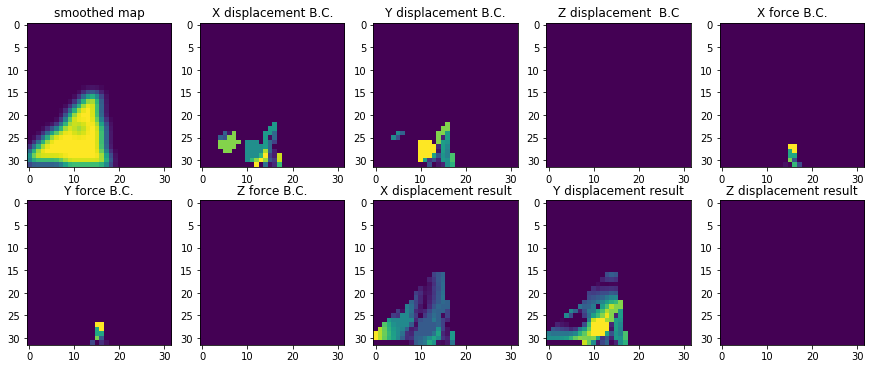

In [20]:
#plot ground truth
sample = 96
sample_bc = np.moveaxis(dataset[0][sample,:,:,:].numpy(), 0, 2)
sample_target = np.moveaxis(dataset[1][sample,:,:,:].numpy(), 0, 2)
print(sample_bc.shape, sample_target.shape)
plot_grid_2d(sample_bc, sample_target)

torch.Size([1, 3, 32, 32])
(1, 4, 32, 32)
(1, 32, 32, 4)


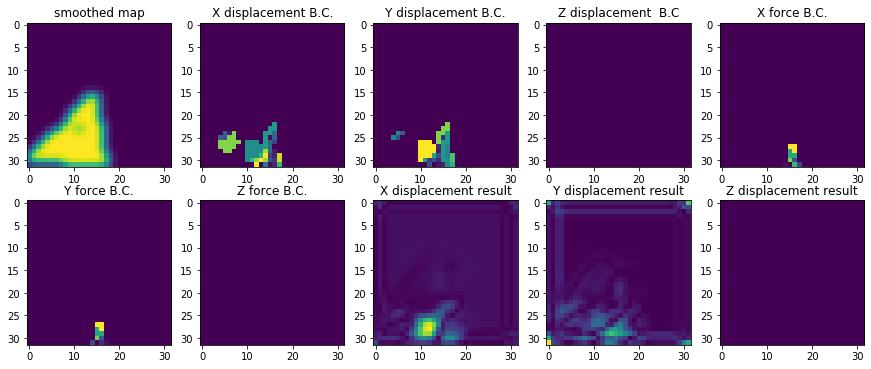

In [41]:
## plot one of the results after passing the convolutional network through it once
sample_prediction = net.forward(dataset[0][sample:sample+1,:,:,:])
print(sample_prediction.shape)
sample_prediction = F.pad(sample_prediction, (0,0,0,0,0,1)).detach().numpy()
print(sample_prediction.shape)
sample_prediction = np.moveaxis(sample_prediction, 1, 3)
print(sample_prediction.shape)


#print(sample_prediction.shape, dataset[0][27:28,:,10,22], sample_prediction[:,:,10,22])
plot_grid_2d(sample_bc, sample_prediction[0,:,:,:])

So one of the conclusions is that the convolutional network was  able to succesfully learn a model that can be applied to a space to generate a result  that correlates to the target. Even with a very small number of samples, the network was able to learn some basic principles about the geometry of the sample and of the relationships between boundary conditions and targets

In [53]:
## get loss of the results
with torch.no_grad():
    print(dataset[1][sample, 1:4, :, :].unsqueeze(0).shape)
    print(net.forward(dataset[0][sample:sample+1,:,:,:]).shape)
    loss_1_it = criterion(dataset[1][sample, 1:4, :, :].unsqueeze(0), net.forward(dataset[0][sample:sample+1,:,:,:]))
    print(f'{loss_1_it: .9f}')

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
 0.000156545


In [32]:
## create a generator to evaluate how loss progresses with multiple applications of the network
def convolute_iteration(conditions, netwrk, repeat = True):
    with torch.no_grad():
        pred = netwrk(conditions) #torch.Size([1, 3, 32, 32])
        new_condition = conditions.clone()
        new_condition[:, 1:4, :, :] = pred
        i=0
        while repeat:
            i +=1
            print(i)
            pred = netwrk(new_condition)
            new_condition = conditions.clone()
            new_condition[:, 1:4, :, :] = pred
            
            yield pred

In [118]:
## create iterator intance for loss plot
predicts = convolute_iteration(dataset[0][sample:sample+1,:,:,:], net)
loss_iterator = []

95
 0.116603315


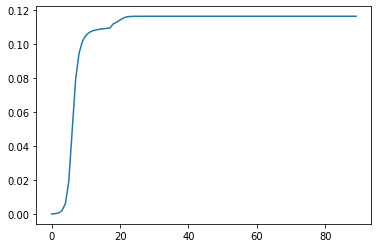

In [213]:
with torch.no_grad():
    
    loss_2_it = criterion(dataset[1][sample, 1:4, :, :].unsqueeze(0), next(predicts))
    loss_iterator.append(loss_2_it)
    print(f'{loss_2_it: .9f}')
    plt.plot(loss_iterator)

What has been shown with this is that subsequent applications of this model don't increase its accuracy, however it does converge to a certain value. The fact that there is convergence is grounds for exploring whether this convergence can be used as a feature of the model itself.

In [215]:
## create iterator intance for prediction plot
predicts = convolute_iteration(dataset[0][sample:sample+1,:,:,:], net)


2
torch.Size([1, 3, 32, 32])
(1, 4, 32, 32)
(1, 32, 32, 4)


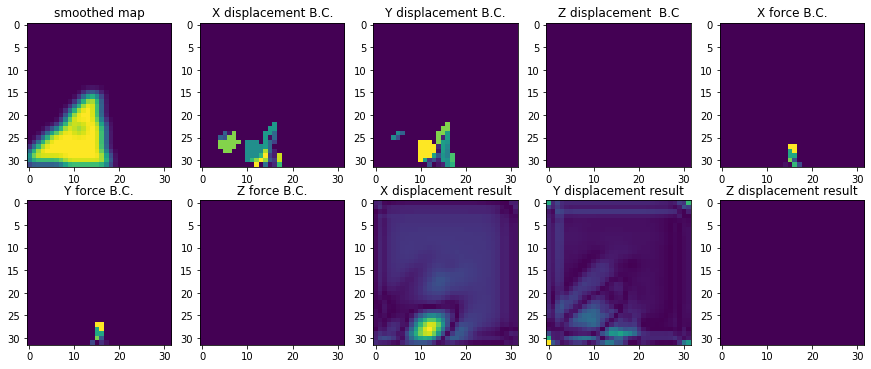

In [217]:
sample_prediction = next(predicts)
print(sample_prediction.shape)
sample_prediction = F.pad(sample_prediction, (0,0,0,0,0,1)).detach().numpy()
print(sample_prediction.shape)
sample_prediction = np.moveaxis(sample_prediction, 1, 3)
print(sample_prediction.shape)


#print(sample_prediction.shape, dataset[0][27:28,:,10,22], sample_prediction[:,:,10,22])
plot_grid_2d(sample_bc, sample_prediction[0,:,:,:])

Now I want to explore a lot of things and their impact on the model's predictions:

- leaning rates
- different conv deconv architectures
- pre-trained models (if models trained on images help with accuracy in this case, then it is possible to use models trained in other types of object for the 3d version)
- attention
- different losses
- increase amount of model forward feeds before doing gradient descent to try to get the model to converge closer to the target value if applied several times
- Other activation strategies

## ENCODER DECODER

In [102]:
##update loging
wandb.init(config={"epochs": 30, "batch_size": 90,'learning_rate': 0.0005, 'architecture':'encoder_decoder_architecture'})

W&B Run: https://app.wandb.ai/walther/Project/runs/1a7sqgcg

In [100]:

## First, see the result of a conv-deconv architecture with exactly the same parameters but that condenses
## the inputs into a feature array first
## define the neural network's general shape

class Encode_decode_Net(nn.Module):
    def __init__(self):
        super(Encode_decode_Net, self).__init__()
        
        ## convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 7, out_channels = 14, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 14, out_channels = 16, kernel_size = 3, padding = 1)
        self.deconv1 = nn.ConvTranspose2d(in_channels = 16, out_channels = 14, kernel_size = 3, padding = 1)
        self.deconv2 = nn.ConvTranspose2d(in_channels = 14, out_channels = 10, kernel_size = 2,stride = 2, padding = 0)
        self.deconv3 = nn.ConvTranspose2d(in_channels = 10, out_channels = 7, kernel_size = 2, stride = 2, padding = 0)
        self.deconv4 = nn.ConvTranspose2d(in_channels = 7, out_channels = 3, kernel_size = 3, padding = 1)
        
        ## activation
        self.hardtanh = nn.Hardtanh()
        self.tanh = nn.Tanh()
        self.prelu = nn.PReLU()
        self.leaky_relu = nn.LeakyReLU()
        
        ## Pooling
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        
    def forward(self, boundary_conditions):
        '''
        torch.Size([1, 7, 32, 32])
        torch.Size([1, 14, 16, 16])
        torch.Size([1, 16, 8, 8])
        torch.Size([1, 14, 8, 8])
        torch.Size([1, 10, 16, 16])
        torch.Size([1, 7, 32, 32])
        torch.Size([1, 3, 32, 32])
        '''
        
        #print(boundary_conditions.shape)
        x = self.conv1(boundary_conditions)
        x = self.maxpool(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv1(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv2(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv3(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv4(x)
        x = self.tanh(x)
        #print(x.shape)
        return x
    
        
net = Encode_decode_Net().cuda().float()

## test to see if getting the correct size
net.forward(dataset[0][0:1,:,:,:].cuda());

In [101]:
## define criterion
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(params = net.parameters(), lr=0.0005, betas=(0.9, 0.999))

In [104]:
%%wandb 
## logging cell magic
##
wandb.watch(net)



## define a general training loop
losses = np.array([0,0,0])
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    boundary_conditions, targets = dataset[0][:90,:,:,:].cuda(), dataset[1][:90,:,:,:].cuda()
    #print(type(boundary_conditions))
    for i, bc in enumerate(boundary_conditions):
        tgt = targets[i, 1:4, :, :].unsqueeze(0)
        bc = bc.unsqueeze(0).cuda()
        #print(i, bc.shape, tgt.shape)

        # get the inputs; data is a list of [boundary_conditions, targets]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        prediction = net(bc)
        loss = criterion(prediction, tgt)
        #print(loss)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 10 mini-batches
            running_val_loss = 0.0
            with torch.no_grad():
                boundary_conditions_val, targets_val = dataset[0][90:,:,:,:].cuda(), dataset[1][90:,:,:,:].cuda()
                for ii, bc_val in enumerate(boundary_conditions_val):
                    tgt_val = targets_val[i, 1:4, :, :].unsqueeze(0)
                    bc_val = bc_val.unsqueeze(0)
                    prediction_val = net(bc_val)
                    val_loss = criterion(prediction_val, tgt_val)
                    running_val_loss+=val_loss.item()
                
            print(f'{epoch + 1} {i + 1} {running_loss} {running_val_loss/10}')
            losses = np.vstack((losses, [epoch, running_loss, running_val_loss]))
            wandb.log({"loss": running_loss})
            wandb.log({"val_loss": running_val_loss})
            #print(losses)
            running_loss = 0.0
            

print('Finished Training')

1 1 0.00016078869521152228 0.00023639252176508308
2 1 0.00016151004820130765 0.0002374786330619827
3 1 0.00016063421207945794 0.000238728744443506
4 1 0.00016117992345243692 0.00023993723589228467
5 1 0.00016057249740697443 0.00024261017388198524
6 1 0.00016048729594331235 0.00024482515582349154
7 1 0.00016053710714913905 0.00024617780436528844
8 1 0.0001602942356839776 0.0002489169521140866
9 1 0.0001611612387932837 0.0002506437842384912
10 1 0.00016029554535634816 0.00025321565772173926
11 1 0.00016172192408703268 0.00025456226139795033
12 1 0.00016040742048062384 0.0002575972888735123
13 1 0.00016229662287514657 0.0002584917048807256
14 1 0.0001617233210708946 0.0002614155877381563
15 1 0.00016344586038030684 0.0002617925871163607
16 1 0.0001620804687263444 0.0002651820032042451
17 1 0.00016433189739473164 0.00026507599250180647
18 1 0.00016368429351132363 0.0002678672186448239
19 1 0.00016520926146768034 0.00026742970949271693
20 1 0.00016458571190014482 0.00027035838866140693
21 1

So this network achieved lower validation losses, but stayed at a higher training loss. Further, prelu showed very similar behaviour to using hardtanh. 

torch.Size([1, 3, 32, 32])
(1, 4, 32, 32)
(1, 32, 32, 4)


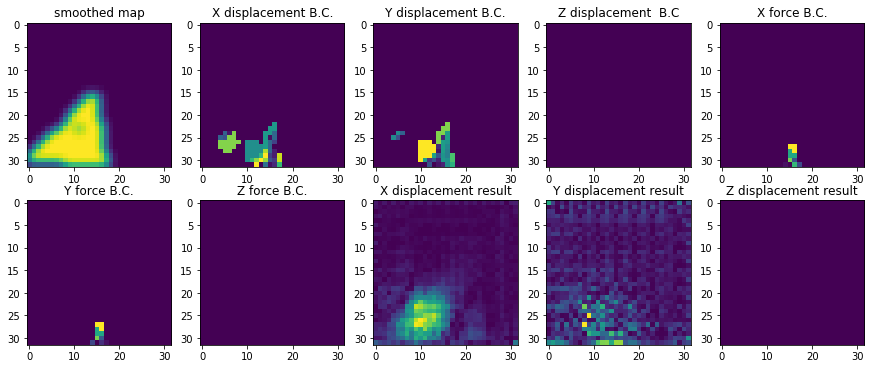

In [105]:
## plot one of the results after passing the convolutional network through it once
sample_prediction = net.cpu().forward(dataset[0][sample:sample+1,:,:,:])
print(sample_prediction.shape)
sample_prediction = F.pad(sample_prediction, (0,0,0,0,0,1)).detach().numpy()
print(sample_prediction.shape)
sample_prediction = np.moveaxis(sample_prediction, 1, 3)
print(sample_prediction.shape)


#print(sample_prediction.shape, dataset[0][27:28,:,10,22], sample_prediction[:,:,10,22])
plot_grid_2d(sample_bc, sample_prediction[0,:,:,:])

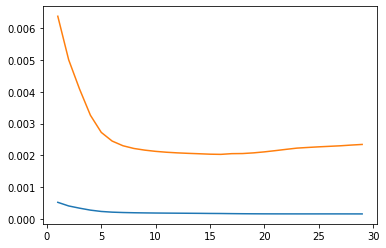

In [62]:
## plot losses over time
plt.plot(losses[2:,0], losses[2:,1:])

## MULTIHEAD ATTENTION

In [93]:
##update loging
wandb.init(config={"epochs": 20, "batch_size": 90,'learning_rate': 0.0002,"amsgrad": True, 'architecture':'attention_architecture_4'})

W&B Run: https://app.wandb.ai/walther/Project/runs/3lkmomc3

In [8]:
## define attention class

class SelfAttention(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(SelfAttention,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//3 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//3 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out,attention

In [97]:
class AttentionNet(nn.Module):
    def __init__(self):
        super(AttentionNet, self).__init__()
        
        ## convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 7, out_channels = 14, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 14, out_channels = 32, kernel_size = 3, padding = 1)
        self.deconv1 = nn.ConvTranspose2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.deconv2 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1)
        self.deconv3 = nn.ConvTranspose2d(in_channels = 32, out_channels = 7, kernel_size = 3, padding = 1)
        self.deconv4 = nn.ConvTranspose2d(in_channels = 7, out_channels = 3, kernel_size = 3, padding = 1)
        
        ## activation
        self.hardtanh = nn.Hardtanh()
        
        ## activation
        self.hardtanh = nn.Hardtanh()
        self.tanh = nn.Tanh()
        self.prelu = nn.PReLU()
        self.leaky_relu = nn.LeakyReLU()
        
        ##possible for later: MultiheadAttention
        self.multihead_attn_in = SelfAttention(in_dim = 14, activation = None)
        self.multihead_attn_out = SelfAttention(in_dim = 3, activation = None)
        self.multihead_attn_middle = SelfAttention(in_dim = 64, activation = None)
    def forward(self, boundary_conditions):
        #print(boundary_conditions.shape)
        x = self.conv1(boundary_conditions)
        x = self.prelu(x)
        x, attn = self.multihead_attn_in(x)
        #print(x.shape)
        x = self.conv2(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv1(x)
        x, attn = self.multihead_attn_middle(x)
        x = self.prelu(x)
       #print(x.shape)
        x = self.deconv2(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv3(x) 
        x = self.prelu(x)
       # print(x.shape)
        x = self.deconv4(x)
        x, attn = self.multihead_attn_out(x)
        x = self.tanh(x)
        #print(x.shape)
        '''
        #print(boundary_conditions.shape)
        x = self.conv1(boundary_conditions)
        #x = self.maxpool(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.conv2(x)
        #x = self.maxpool(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv1(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv2(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv3(x)
        x = self.prelu(x)
        #print(x.shape)
        x = self.deconv4(x)
        x = self.tanh(x)
        #print(x.shape)
        '''
        return x
    
net = AttentionNet().cuda().float()

## test to see if getting the correct size
net.forward(dataset[0][0:1,:,:,:].cuda())

tensor([[[[0.0645, 0.0419, 0.0345,  ..., 0.0331, 0.0346, 0.0388],
          [0.0750, 0.0556, 0.0496,  ..., 0.0482, 0.0507, 0.0447],
          [0.0746, 0.0562, 0.0516,  ..., 0.0496, 0.0518, 0.0457],
          ...,
          [0.0703, 0.0530, 0.0480,  ..., 0.0487, 0.0498, 0.0432],
          [0.0685, 0.0572, 0.0607,  ..., 0.0601, 0.0605, 0.0566],
          [0.0786, 0.0755, 0.0772,  ..., 0.0802, 0.0821, 0.0741]],

         [[0.0659, 0.0688, 0.0710,  ..., 0.0724, 0.0740, 0.0812],
          [0.0797, 0.0729, 0.0728,  ..., 0.0736, 0.0720, 0.0511],
          [0.0776, 0.0730, 0.0725,  ..., 0.0738, 0.0764, 0.0528],
          ...,
          [0.0792, 0.0771, 0.0778,  ..., 0.0742, 0.0780, 0.0534],
          [0.0808, 0.0773, 0.0768,  ..., 0.0740, 0.0776, 0.0527],
          [0.0805, 0.0804, 0.0785,  ..., 0.0729, 0.0716, 0.0429]],

         [[0.1875, 0.1919, 0.1932,  ..., 0.1948, 0.1931, 0.1684],
          [0.1586, 0.1569, 0.1567,  ..., 0.1579, 0.1573, 0.1338],
          [0.1636, 0.1618, 0.1621,  ..., 0

In [98]:
## define criterion
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(params = net.parameters(), lr=0.0005, betas=(0.9, 0.999), amsgrad = True)

In [99]:
%%wandb 
## logging cell magic
##
wandb.watch(net)



## define a general training loop
losses = np.array([0,0,0])
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    boundary_conditions, targets = dataset[0][:90,:,:,:].cuda(), dataset[1][:90,:,:,:].cuda()
    #print(type(boundary_conditions))
    for i, bc in enumerate(boundary_conditions):
        tgt = targets[i, 1:4, :, :].unsqueeze(0)
        bc = bc.unsqueeze(0).cuda()
        #print(i, bc.shape, tgt.shape)

        # get the inputs; data is a list of [boundary_conditions, targets]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        prediction = net(bc)
        loss = criterion(prediction, tgt)
        #print(loss)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 10 mini-batches
            running_val_loss = 0.0
            with torch.no_grad():
                boundary_conditions_val, targets_val = dataset[0][90:,:,:,:].cuda(), dataset[1][90:,:,:,:].cuda()
                for ii, bc_val in enumerate(boundary_conditions_val):
                    tgt_val = targets_val[i, 1:4, :, :].unsqueeze(0)
                    bc_val = bc_val.unsqueeze(0)
                    prediction_val = net(bc_val)
                    val_loss = criterion(prediction_val, tgt_val)
                    running_val_loss+=val_loss.item()
                
            print(f'{epoch + 1} {i + 1} {running_loss} {running_val_loss/10}')
            losses = np.vstack((losses, [epoch, running_loss, running_val_loss]))
            wandb.log({"loss": running_loss})
            wandb.log({"val_loss": running_val_loss})
            #print(losses)
            running_loss = 0.0
            

print('Finished Training')

1 1 0.011635631322860718 0.013341785781085492
2 1 0.0006126444786787033 0.0007215454534161836
3 1 0.00046975346049293876 0.0005446697439765557
4 1 0.0003758525417651981 0.0004425953462487087
5 1 0.00032358913449570537 0.0003872680739732459
6 1 0.00027915736427530646 0.00033894817752297966
7 1 0.00024992419639602304 0.0003102976770605892
8 1 0.0002269387769047171 0.0002899609171436168
9 1 0.00021107593784108758 0.0002756848829449154
10 1 0.00019952523871324956 0.00026670913212001324
11 1 0.00018997536972165108 0.00025635100610088557
12 1 0.0001804224302759394 0.00023714160779491066
13 1 0.00017500616377219558 0.00023348235408775507
14 1 0.0001698491396382451 0.00023285355855477973
15 1 0.00016464910004287958 0.00022844894701847806
16 1 0.0001616553054191172 0.00022760464053135366
17 1 0.00015694223111495376 0.0002286567774717696
18 1 0.00015384811558760703 0.000229254575970117
19 1 0.0001503427338320762 0.00023039705702103673
20 1 0.0001464941306039691 0.00023356356905424036
Finished Tr

So the errors were lower, and it trained and started overfitting extremely quick with a starting attention layer and lr of 0.0005. Looking at the image below, it also learned very well how to identify where the element is. Using attention is definitely a step-up from other strategies.

torch.Size([1, 3, 32, 32])
(1, 4, 32, 32)
(1, 32, 32, 4)


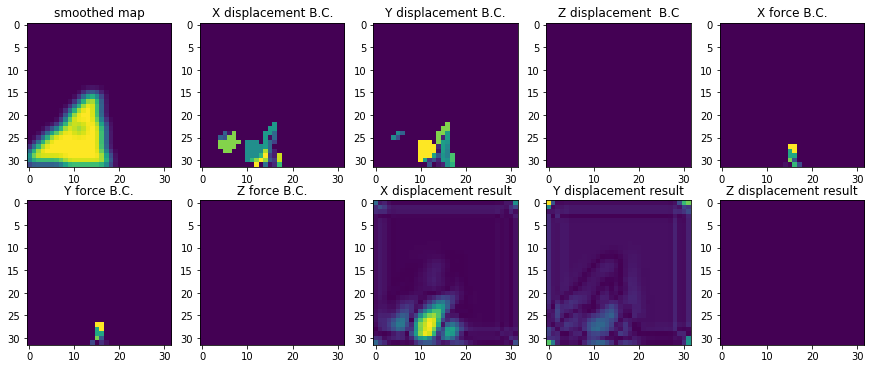

In [100]:
sample = 96
sample_bc = np.moveaxis(dataset[0][sample,:,:,:].numpy(), 0, 2)
## plot one of the results after passing the convolutional network through it once
sample_prediction = net.cpu().forward(dataset[0][sample:sample+1,:,:,:])
print(sample_prediction.shape)
sample_prediction = F.pad(sample_prediction, (0,0,0,0,0,1)).detach().numpy()
print(sample_prediction.shape)
sample_prediction = np.moveaxis(sample_prediction, 1, 3)
print(sample_prediction.shape)


#print(sample_prediction.shape, dataset[0][27:28,:,10,22], sample_prediction[:,:,10,22])
plot_grid_2d(sample_bc, sample_prediction[0,:,:,:])

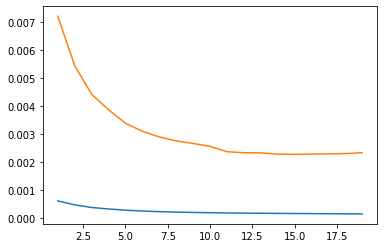

In [101]:
## plot losses over time
plt.plot(losses[2:,0], losses[2:,1:])

## VGG 16
For this section I'll attempt to use a pre-trained architecture to see if that has any effect on the results

In [288]:
##update loging
wandb.init(config={"epochs": 201,'trainable': True, "batch_size": 90,'learning_rate': 0.00035,"amsgrad": False, 'architecture':'vgg16_architecture_4'})

W&B Run: https://app.wandb.ai/walther/Project/runs/21sxqo2h

In [206]:
import torchvision.models as models

In [289]:
vgg16 = models.vgg16(pretrained=True)

In [262]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [290]:
## get convolutional portion of model
net = vgg16.features.cuda()

## change first layer to the correct feature size
net[0] = nn.Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# append last layer of correct feature size and correct activation function
net = nn.Sequential(*net, (nn.Conv2d(512, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))))
net = nn.Sequential(*net, nn.Tanh())

# send model to gpu
net = net.cuda()

# remove the max pool layers
layer_list = []
for layer in net:
    if not(type(layer) == torch.nn.modules.pooling.MaxPool2d):
        layer_list.append(layer)
        
# create a model without the maxpool layers
net = nn. Sequential(*layer_list)
net

Sequential(
  (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU(inplace=True)
  (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [291]:
for i, layer in enumerate(net.parameters()):
     print(i, layer.requires_grad)

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 True
15 True
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True


In [280]:
## set to only train the added parameters
for i, layer in enumerate(net.parameters()):
    if not(i == 0 or i == 27):
        layer.requires_grad = False
    print(i, layer.requires_grad)

0 True
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 True


In [225]:
net.forward(dataset[0][0:1,:,:,:].cuda()).shape

torch.Size([1, 3, 32, 32])

In [292]:
## define criterion
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(params = net.parameters(), lr=0.00035, betas=(0.9, 0.999), amsgrad = False)

In [293]:
%%wandb 
## logging cell magic
##
wandb.watch(net)



## define a general training loop
losses = np.array([0,0,0])
for epoch in range(201):  # loop over the dataset multiple times

    running_loss = 0.0
    boundary_conditions, targets = dataset[0][:90,:,:,:].cuda(), dataset[1][:90,:,:,:].cuda()
    #print(type(boundary_conditions))
    for i, bc in enumerate(boundary_conditions):
        tgt = targets[i, 1:4, :, :].unsqueeze(0)
        material_matrix = boundary_conditions[i, 0, :, :].unsqueeze(0).repeat([1,3,1,1])

        bc = bc.unsqueeze(0).cuda()
        #print(i, bc.shape, tgt.shape)

        # get the inputs; data is a list of [boundary_conditions, targets]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        prediction = net(bc)
        loss = criterion(prediction*material_matrix, tgt*material_matrix)
        # weigh loss based on material map
        
       
        #print(loss.shape)
        loss = loss.mean()
        
        #print(stp)
        #print(loss)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 10 mini-batches
            running_val_loss = 0.0
            with torch.no_grad():
                boundary_conditions_val, targets_val = dataset[0][90:,:,:,:].cuda(), dataset[1][90:,:,:,:].cuda()
                for ii, bc_val in enumerate(boundary_conditions_val):
                    tgt_val = targets_val[i, 1:4, :, :].unsqueeze(0)
                    bc_val = bc_val.unsqueeze(0)
                    prediction_val = net(bc_val)
                    val_loss = criterion(prediction_val*material_matrix, tgt_val*material_matrix)

                    running_val_loss+=val_loss.item()
                
            print(f'{epoch + 1} {i + 1} {running_loss} {running_val_loss/10}')
            losses = np.vstack((losses, [epoch, running_loss, running_val_loss]))
            wandb.log({"loss": running_loss})
            wandb.log({"val_loss": running_val_loss})
            #print(losses)
            running_loss = 0.0
            

print('Finished Training')

1 1 0.0015792734920978546 0.00017977367097046226
2 1 0.00016407993098255247 8.966045925262733e-06
3 1 0.00015048979548737407 4.022773623546527e-06
4 1 0.0001427479728590697 1.9869791685778184e-06
5 1 0.00013830620446242392 1.3903957437833015e-06
6 1 0.0001357730943709612 1.3222631991993694e-06
7 1 0.0001342837349511683 1.4272034036366677e-06
8 1 0.00013339871657080948 1.5668695027670765e-06
9 1 0.00013285342720337212 1.6936329870986811e-06
10 1 0.00013253168435767293 1.7968291331271757e-06
11 1 0.000132327142637223 1.8740824884844188e-06
12 1 0.00013212583144195378 1.92634201994224e-06
13 1 0.000132059765746817 1.9683981122398107e-06
14 1 0.00013193082122597843 1.99935209366231e-06
15 1 0.0001318930007982999 2.0200708604534156e-06
16 1 0.00013189291348680854 2.040558024418715e-06
17 1 0.000131856111693196 2.051758622201305e-06
18 1 0.00013189979654271156 2.0575352891682997e-06
19 1 0.00013189562014304101 2.072022812171781e-06
20 1 0.00013183565170038491 2.087311906961986e-06
21 1 0.000

164 1 0.00013197952648624778 2.122373598467675e-06
165 1 0.00013197952648624778 2.122373598467675e-06
166 1 0.00013197952648624778 2.122373598467675e-06
167 1 0.00013197952648624778 2.1223740077402908e-06
168 1 0.00013197952648624778 2.1223740077402908e-06
169 1 0.00013197952648624778 2.122374553437112e-06
170 1 0.00013197952648624778 2.122373598467675e-06
171 1 0.00013197952648624778 2.122374553437112e-06
172 1 0.00013197952648624778 2.122373598467675e-06
173 1 0.00013197952648624778 2.122374553437112e-06
174 1 0.00013197952648624778 2.122373598467675e-06
175 1 0.00013197952648624778 2.122374553437112e-06
176 1 0.00013197952648624778 2.122373598467675e-06
177 1 0.00013197952648624778 2.122374553437112e-06
178 1 0.00013197952648624778 2.122373598467675e-06
179 1 0.00013197952648624778 2.122374553437112e-06
180 1 0.00013197952648624778 2.122373598467675e-06
181 1 0.00013197952648624778 2.122374553437112e-06
182 1 0.00013197952648624778 2.122373598467675e-06
183 1 0.00013197952648624778 

So using a pre-trained model as a feature extractor does seem to help. It was able to learn the dataset in about 4 epochs, using only the new layers as trainable. Allowing the entire model to train on the data from the pre-trained state led to lowest validation loss yet, which was achieved in 3 epochs. This is too good to be true. What became obvious is that the model is overfitting the data and completely ignoring the displacement fields, since it is much easier to simply guess that everything will be zero. A solution to this might be to weigh the loss function based on the material map, with losses inside of the material map being higher than losses outside of it.

torch.Size([1, 3, 32, 32])
(1, 4, 32, 32)
(1, 32, 32, 4)


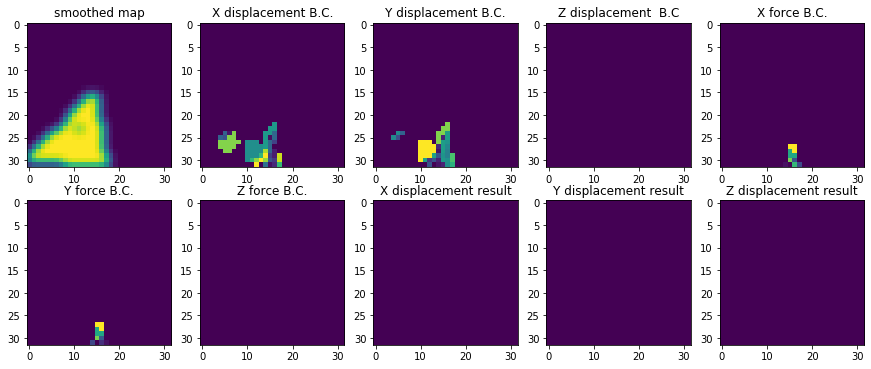

In [294]:
sample = 96
sample_bc = np.moveaxis(dataset[0][sample,:,:,:].numpy(), 0, 2)
## plot one of the results after passing the convolutional network through it once
sample_prediction = net.cpu().forward(dataset[0][sample:sample+1,:,:,:])
print(sample_prediction.shape)
sample_prediction = F.pad(sample_prediction, (0,0,0,0,0,1)).detach().numpy()
print(sample_prediction.shape)
sample_prediction = np.moveaxis(sample_prediction, 1, 3)
print(sample_prediction.shape)


#print(sample_prediction.shape, dataset[0][27:28,:,10,22], sample_prediction[:,:,10,22])
plot_grid_2d(sample_bc, sample_prediction[0,:,:,:])